In [180]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms

In [181]:
script_dir = os.getcwd()
emotion_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression")
emotion_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")

scene_weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
scene_checkpoint = torch.hub.load_state_dict_from_url(scene_weights_url, map_location="cpu")

scene_model = models.resnet18(num_classes=365)
scene_model.fc = nn.Linear(scene_model.fc.in_features, 365)
scene_state_dict = {k.replace("module.", ""): v for k, v in scene_checkpoint["state_dict"].items()}
scene_model.load_state_dict(scene_state_dict)
scene_model.eval()

# Preprocessing, the standard torchvision normalization for ResNet, VGG, DenseNet...
scene_tf = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1006.07it/s]


In [182]:
from deepproblog.network import Network 
import torch.nn.functional as F

# Wrap HF model so forward() returns logits and handles list input
class HFWrapper(nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model

    def forward(self, x):
        # Handle the case where DeepProbLog passes a list of tensors
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            # Add batch dimension if missing
            x = x.unsqueeze(0)
            
        outputs = self.hf_model(x)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1)
        return probs
    
class SceneWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Handle the case where DeepProbLog passes a list of tensors
        if isinstance(x, list):
            x = torch.stack(x, dim=0)
        elif len(x.shape) == 3:
            # Add batch dimension if missing
            x = x.unsqueeze(0)
            
        logits = self.model(x)
        probs = F.softmax(logits, dim=-1)
        return probs

scene_model = SceneWrapper(scene_model)
emotion_model = HFWrapper(emotion_model)

In [183]:
# Create a dataframe for the FindingEmo dataset
import os
import pandas as pd
import random
from io import StringIO
import matplotlib.pyplot as plt
script_dir = os.getcwd()
labels_dir = os.path.join(script_dir, "../data/findingemo/labels")
csv_path = os.path.join(labels_dir, "annotations_cleaned.csv")
df_findingEmo = pd.read_csv(csv_path)

In [184]:
df_findingEmo.head()

,image_path,valence,arousal,emotion
0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,2,Trust
1,Run_2/Frustrated forty-something office/team-w...,0,2,Interest
2,Run_1/Violent youth festival/1042373588.jpg,2,2,Interest
3,Run_2/Remorseful toddlers court of law/dcfs-co...,1,2,Interest
4,Run_2/Shame elderly sports/3364887-46.jpg,0,3,Apprehension


In [185]:
df_findingEmo.head()

,image_path,valence,arousal,emotion
0,Run_2/Loving toddlers sports/haiti-kids.jpg,0,2,Trust
1,Run_2/Frustrated forty-something office/team-w...,0,2,Interest
2,Run_1/Violent youth festival/1042373588.jpg,2,2,Interest
3,Run_2/Remorseful toddlers court of law/dcfs-co...,1,2,Interest
4,Run_2/Shame elderly sports/3364887-46.jpg,0,3,Apprehension


In [186]:
print(len(df_findingEmo))

21372


In [187]:
# # The dataset contains images that cannot be loaded, we will filter them out
# # More efficient approach - check validity and filter
# print(f"Starting with {len(df_findingEmo)} images")

# def is_image_valid(image_path, base_dir):
#     """Check if image exists and can be loaded"""
#     img_path = os.path.join(base_dir, image_path)
#     # get the index of the row where image_path is located
#     row_index = df_findingEmo[df_findingEmo['image_path'] == image_path].index[0]
#     # print every 100th index
#     if row_index % 100 == 0:
#         print(f"Checking image {row_index}/{len(df_findingEmo)}: {img_path}")
    
#     if not os.path.exists(img_path):
#         return False
    
#     try:
#         img = cv2.imread(img_path)
#         return img is not None
#     except:
#         return False

# # Apply validation to all rows at once
# base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")
# valid_mask = df_findingEmo['image_path'].apply(lambda x: is_image_valid(x, base_findingemo_dir))

# # Filter dataframe to keep only valid images
# df_findingEmo_cleaned = df_findingEmo[valid_mask].reset_index(drop=True)

# print(f"Filtered to {len(df_findingEmo_cleaned)} valid images")
# print(f"Removed {len(df_findingEmo) - len(df_findingEmo_cleaned)} invalid images")

# # Update the main dataframe
# df_findingEmo = df_findingEmo_cleaned

# # Write to a new CSV to avoid redoing this
# df_findingEmo.to_csv(os.path.join(labels_dir, "annotations_cleaned.csv"), index=False)

Processing image: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\../data/findingemo\Run_2/Somber students shop/urn-publicid-ap-org-11431e698aa5451eb0b88ea41e4e8496Afghanistan_94367-1020x521.jpg


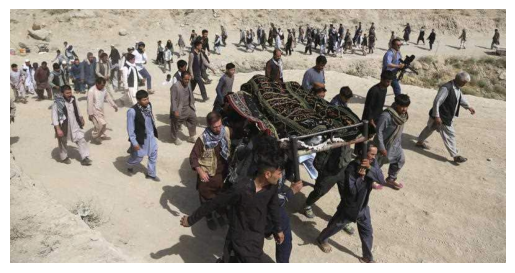

Found 1 face(s)

Face 1:


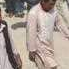

Face 1 top emotions:
  angry: 0.5857
  happy: 0.1944
  neutral: 0.0754

Face detection completed successfully!


In [188]:
from IPython.display import display
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image

base_findingemo_dir = os.path.join(script_dir, "../data/findingemo")

threshold = 0

emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Pick a random image from the findingemo dataset
random_idx = random.randint(0, len(df_findingEmo) - 1)
test_img_path = os.path.join(base_findingemo_dir, df_findingEmo.iloc[random_idx]['image_path'])

test_img = cv2.imread(test_img_path)

print(f"Processing image: {test_img_path}")
# Display the original image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Use OpenCV's built-in Haar Cascade face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert to grayscale for face detection
gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

if len(faces) == 0:
    print("No faces detected in the image.")
else:
    print(f"Found {len(faces)} face(s)")
    
    for i, (x, y, w, h) in enumerate(faces):
        # Extract face region
        face_crop = test_img[y:y+h, x:x+w]
        
        # feed the cropped face to the emotion model
        face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
        face_pil = Image.fromarray(face_rgb)
        
        face_input = emotion_processor(images=face_pil, return_tensors="pt")
        with torch.no_grad():
            face_emotion_probs = emotion_model(face_input['pixel_values'])
            if torch.max(face_emotion_probs) < threshold:
                continue
            topk_face_emotions = torch.topk(face_emotion_probs, k=3).indices.squeeze().tolist()

            print(f"\nFace {i+1}:")
            display(face_pil)  # Display the cropped face

            print(f"Face {i+1} top emotions:")
            for idx in topk_face_emotions:
                print(f"  {emotions[idx]}: {face_emotion_probs[0, idx].item():.4f}")

print("\nFace detection completed successfully!")

In [189]:
# train_test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_findingEmo, test_size=0.2, random_state=42)

# reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [190]:
len(train_df), len(test_df)

(17097, 4275)

In [191]:
test_df.head()

,image_path,valence,arousal,emotion
0,Run_2/Tearful seniors ceremony/north-korean-fe...,-2,5,Grief
1,Run_2/Optimistic people festival/film-festival...,2,3,Serenity
2,Run_2/Appreciative elderly office/5863790318_8...,0,1,Boredom
3,Run_2/Appalled children soccer/paul-gascoigne-...,0,4,Apprehension
4,Run_2/Guilt adolescents theater/Crucible_10-12...,-2,4,Apprehension


In [192]:
# Image access (tensors) - separate classes for different preprocessing
class FindingEmoFaceImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use HuggingFace processor for face emotion model
        face_inputs = emotion_processor(images=img_pil, return_tensors="pt")
        return face_inputs['pixel_values'].squeeze(0)  # Remove batch dimension

class FindingEmoSceneImages(object):
    def __init__(self, subset):
        self.subset = subset
        if self.subset == "train":
            self.dataframe = train_df.copy()
        else:
            self.dataframe = test_df.copy()
            
    def __getitem__(self, item):
        index = int(item[0]) if isinstance(item, (tuple, list)) else int(item)
        
        image_path = self.dataframe["image_path"][index]
        if image_path.startswith('/'):
            image_path = image_path[1:]
        
        img_path = os.path.join(base_findingemo_dir, image_path)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
            
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image: {img_path}")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img)
        
        # Use scene transforms for scene model
        scene_tensor = scene_tf(img_pil)
        return scene_tensor

# Create separate instances
FindingEmoFace_train = FindingEmoFaceImages("train")
FindingEmoFace_test = FindingEmoFaceImages("test")
FindingEmoScene_train = FindingEmoSceneImages("train") 
FindingEmoScene_test = FindingEmoSceneImages("test")

In [193]:
emotion_categories = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

mapping = {
    'Acceptance': 'neutral',
    'Admiration': 'happy',
    'Amazement': 'surprise',
    'Anger': 'angry',
    'Annoyance': 'angry',
    'Anticipation': 'neutral',  
    'Apprehension': 'fear',
    'Boredom': 'neutral',
    'Disgust': 'disgust',
    'Distraction': 'neutral',
    'Ecstasy': 'happy',
    'Fear': 'fear',
    'Grief': 'sad',
    'Interest': 'neutral',
    'Joy': 'happy',
    'Loathing': 'disgust',
    'Pensiveness': 'sad',
    'Rage': 'angry',
    'Sadness': 'sad',
    'Serenity': 'happy',
    'Surprise': 'surprise',
    'Terror': 'fear',
    'Trust': 'happy',    
    'Vigilance': 'neutral' 
}

model_emotion_to_index = {emotion: idx for idx, emotion in enumerate(emotion_categories)}

def map_findingemo_emotion_to_index(findingemo_emotion):
    # Map FindingEmo emotion string to emotion model index, neutral is default when not found
    model_emotion = mapping.get(findingemo_emotion, 'neutral')
    return model_emotion_to_index[model_emotion]

In [194]:
# Mapping for the scene categories. Read them from ../data/places365/categories_places365.txt
scene_categories = []
with open(os.path.join(script_dir, "../data/places365/categories_places365.txt")) as f:
    for line in f:
        scene = line.strip().split(' ')[0][3:]
        scene_categories.append(scene)

model_scene_to_index = {scene: idx for idx, scene in enumerate(scene_categories)}

# def map_findingemo_scene_to_index(findingemo_scene):
#     # Map FindingEmo scene string to scene model index, 'living_room' is default when not found
#     model_scene = mapping.get(findingemo_scene, 'living_room')
#     return model_scene_to_index[model_scene]

In [195]:
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.dataset import Dataset, DataLoader
from torch.utils.data import Dataset as TorchDataset
from problog.logic import Term, Constant
from deepproblog.query import Query
from deepproblog.train import train_model

In [196]:
# First, create the network objects (you need to add this part)
simple_face_network = Network(emotion_model, "face_net", batching=True)
simple_scene_network = Network(scene_model, "scene_net", batching=True)

num_emotions = len(emotion_categories)
num_scenes = len(scene_categories)

emotion_indices = list(range(num_emotions))
scene_indices = list(range(num_scenes))

# Create integrated Prolog file with dynamic indices
prolog = f"""
nn(face_net,[X],Y,{emotion_indices}) :: face_emotion(X,Y).
nn(scene_net,[X],Y,{scene_indices}) :: scene_category(X,Y).

% Query both face emotion and scene category for the same image
emotion_and_scene(FaceImg, SceneImg, EmotionIdx, SceneIdx) :-
    face_emotion(FaceImg, EmotionIdx),
    scene_category(SceneImg, SceneIdx).

% Individual queries
emotion(FaceImg, EmotionIdx) :-
    face_emotion(FaceImg, EmotionIdx).

scene(SceneImg, SceneIdx) :-
    scene_category(SceneImg, SceneIdx).
"""

# Write the integrated Prolog file
with open(os.path.join(script_dir, "integrated.pl"), "w") as f:
    f.write(prolog)

In [197]:
train_indices = list(range(len(train_df))) 
test_indices = list(range(len(test_df))) 

In [198]:
# Create integrated model
integrated_model = Model(os.path.join(script_dir, "integrated.pl"), [simple_face_network, simple_scene_network])
integrated_model.set_engine(ExactEngine(integrated_model), cache=True)

# Register tensor sources
integrated_model.add_tensor_source("train_face", FindingEmoFace_train)
integrated_model.add_tensor_source("test_face", FindingEmoFace_test)
integrated_model.add_tensor_source("train_scene", FindingEmoScene_train)
integrated_model.add_tensor_source("test_scene", FindingEmoScene_test)

Caching ACs


In [199]:

class SocialCognition(Dataset, TorchDataset):
    def __init__(self, indices, subset="train"):
        self.indices = indices
        self.subset = subset
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        real_idx = self.indices[index]
        if self.subset == "train":
            face_tensor = FindingEmoFace_train[(real_idx,)]
            scene_tensor = FindingEmoScene_train[(real_idx,)]
            emotion_idx = map_findingemo_emotion_to_index(str(train_df.iloc[real_idx]["emotion"]))
        else:
            face_tensor = FindingEmoFace_test[(real_idx,)]
            scene_tensor = FindingEmoScene_test[(real_idx,)]
            emotion_idx = map_findingemo_emotion_to_index(str(test_df.iloc[real_idx]["emotion"]))
        
        return (face_tensor, scene_tensor), emotion_idx
    
    def to_query(self, i):
       pass
    
    def _get_predicted_scene(self, real_idx):
        # Get the most likely scene for this image using the scene network
        if self.subset == "train":
            scene_tensor = FindingEmoScene_train[(real_idx,)]
        else:
            scene_tensor = FindingEmoScene_test[(real_idx,)]
        
        with torch.no_grad():
            scene_tensor = scene_tensor.unsqueeze(0)
            scene_probs = scene_model(scene_tensor)
            predicted_scene_idx = torch.argmax(scene_probs, dim=1).item()
        
        return predicted_scene_idx

Image path: Run_2/Optimistic people conference/surgeryg493216413_1527923.jpg


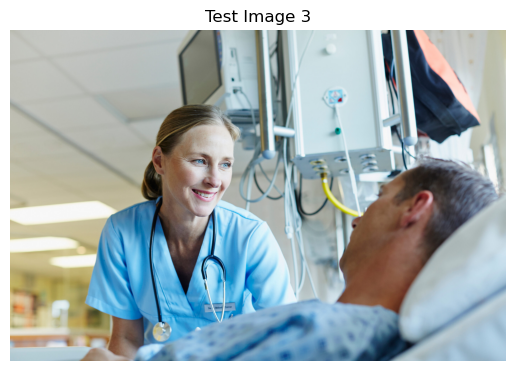

Ground truth emotion: Trust (index: 3)
Predicted scene: operating_room (index: 248)
Emotion query: P(happy) = 0.7986
Scene query: P(operating_room) = 0.3405
Combined query: P(happy AND operating_room) = 0.2719


In [ ]:
# Test sample
test_sample_idx = train_indices[3]

# Display the image for reference
image_path = train_df.iloc[test_sample_idx]['image_path']
img_path = os.path.join(base_findingemo_dir, image_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.title(f"Test Image {test_sample_idx}")
plt.show()

# Get ground truth emotion
true_emotion = train_df.iloc[test_sample_idx]['emotion']
true_emotion_idx = map_findingemo_emotion_to_index(str(true_emotion))
print(f"Ground truth emotion: {true_emotion} (index: {true_emotion_idx})")

# Create dataset with predicted scenes
predicted_dataset = SocialCognition(
    [test_sample_idx], 
    subset="train", 
)

# Get predicted scene
predicted_scene_idx = predicted_dataset._get_predicted_scene(test_sample_idx)
predicted_scene_name = scene_categories[predicted_scene_idx]
print(f"Predicted scene: {predicted_scene_name} (index: {predicted_scene_idx})")

# Test all query types with predicted scene
emotion_query_pred = Query(
    Term("emotion", Term("tensor", Term("train_face", Constant(test_sample_idx))), Constant(true_emotion_idx)),
    substitution={}
)

scene_query_pred = Query(
    Term("scene", Term("tensor", Term("train_scene", Constant(test_sample_idx))), Constant(predicted_scene_idx)),
    substitution={}
)

combined_query_pred = Query(
    Term("emotion_and_scene", 
         Term("tensor", Term("train_face", Constant(test_sample_idx))),
         Term("tensor", Term("train_scene", Constant(test_sample_idx))),
         Constant(true_emotion_idx), 
         Constant(predicted_scene_idx)),
    substitution={}
)


results_pred = integrated_model.solve([emotion_query_pred, scene_query_pred, combined_query_pred])

emotion_prob_pred = list(results_pred[0].result.values())[0]
scene_prob_pred = list(results_pred[1].result.values())[0]
combined_prob_pred = list(results_pred[2].result.values())[0]

print(f"Emotion query: P({emotion_categories[true_emotion_idx]}) = {emotion_prob_pred:.4f}")
print(f"Scene query: P({predicted_scene_name}) = {scene_prob_pred:.4f}")
print(f"Combined query: P({emotion_categories[true_emotion_idx]} AND {predicted_scene_name}) = {combined_prob_pred:.4f}")